In [1]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#from __future__ import division
from sklearn.cluster import KMeans

In [2]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [3]:
tx_data = pd.read_csv('C:\\Users\\Om Computers\\Downloads\\cap_stone_all_seen\\Capstone_project\\4seenshot\\df_r.csv')

In [4]:
tx_data['Invoice_DateTime'] = pd.to_datetime(tx_data['Invoice_DateTime'])

In [ ]:
tx_data.head()

In [6]:
tx_data['Invoice_DateTime'].describe()

count                  936236
unique                 488018
top       2015-09-30 18:30:26
freq                       11
first     2012-04-02 17:04:33
last      2016-10-31 22:53:06
Name: Invoice_DateTime, dtype: object

In [8]:
tx_3m = tx_data[(tx_data.Invoice_DateTime < date(2013,6,1)) & (tx_data.Invoice_DateTime >= date(2013,3,1))].reset_index(drop=True)
tx_6m = tx_data[(tx_data.Invoice_DateTime >= date(2013,6,1)) & (tx_data.Invoice_DateTime < date(2013,12,1))].reset_index(drop=True)

C:\Users\Om Computers\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.
C:\Users\Om Computers\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [93]:
len(tx_3m)

19348

# 3m only

In [9]:
tx_3m['Invoice_DateTime'].describe()

count                   19348
unique                   9888
top       2013-03-26 15:01:25
freq                        5
first     2013-03-01 09:49:03
last      2013-05-31 20:14:46
Name: Invoice_DateTime, dtype: object

In [10]:
tx_user = pd.DataFrame(tx_3m['Customer No.'].unique())
tx_user.columns = ['Customer No.']

# Recency

In [11]:
tx_max_purchase = tx_3m.groupby('Customer No.').Invoice_DateTime.max().reset_index()

In [12]:
tx_max_purchase.columns = ['Customer No.','MaxPurchaseDate']

In [13]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [14]:
tx_user = pd.merge(tx_user, tx_max_purchase[['Customer No.','Recency']], on='Customer No.')

In [15]:
tx_user.head()

,Customer No.,Recency
0,E23287,62
1,5650,36
2,10921,91
3,10901,91
4,10884,91


In [16]:
tx_user.Recency.describe()

count    8059.000000
mean       39.898499
std        26.406080
min         0.000000
25%        17.000000
50%        37.000000
75%        62.000000
max        91.000000
Name: Recency, dtype: float64

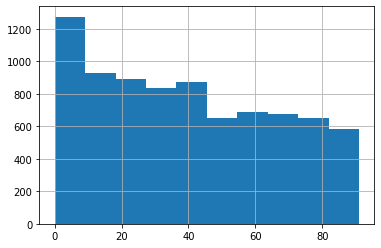

In [17]:
tx_user['Recency'].hist()

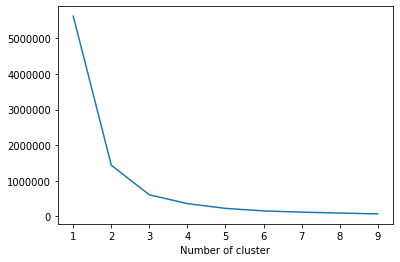

In [18]:
sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [19]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [20]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,2435.0,73.120329,9.777049,57.0,65.0,73.0,81.0,91.0
1,2976.0,11.959677,7.978272,0.0,5.0,11.0,19.0,26.0
2,2648.0,40.748489,8.343279,27.0,34.0,40.5,48.0,56.0


In [21]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [22]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [24]:
tx_user.head()

,Customer No.,Recency,RecencyCluster
0,E23287,62,0
1,10921,91,0
2,10901,91,0
3,10884,91,0
4,10648,91,0


# Frequency

In [25]:
tx_frequency = tx_3m.groupby('Customer No.').Invoice_DateTime.count().reset_index()

In [26]:
tx_frequency.columns = ['Customer No.','Frequency']

In [27]:
tx_frequency.head()

,Customer No.,Frequency
0,1,1
1,1000,2
2,10001,1
3,1001,2
4,10021,3


In [28]:
tx_user = pd.merge(tx_user, tx_frequency, on='Customer No.')

In [29]:
tx_user.head()

,Customer No.,Recency,RecencyCluster,Frequency
0,E23287,62,0,2
1,10921,91,0,2
2,10901,91,0,2
3,10884,91,0,2
4,10648,91,0,1


In [30]:
tx_user.Frequency.describe()

count    8059.000000
mean        2.400794
std         1.923759
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        84.000000
Name: Frequency, dtype: float64

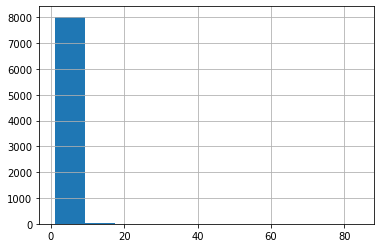

In [31]:
tx_user.query('Frequency < 100')['Frequency'].hist()

C:\Users\Om Computers\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Om Computers\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Om Computers\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

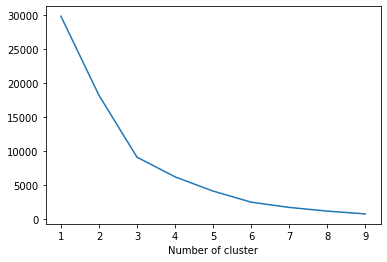

In [32]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [33]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [34]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1073.0,5.089469,2.227167,4.0,4.0,4.0,5.0,30.0
1,6983.0,1.960905,0.660105,1.0,2.0,2.0,2.0,3.0
2,3.0,64.666667,19.008770,46.0,55.0,64.0,74.0,84.0


In [35]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

# Monetary Value

In [36]:
#tx_3m['Revenue'] = tx_3m['UnitPrice'] * tx_3m['Quantity']
tx_3m['Revenue'] = tx_3m['Net value'] 

In [37]:
tx_revenue = tx_3m.groupby('Customer No.').Revenue.sum().reset_index()

In [38]:
tx_revenue.head()

,Customer No.,Revenue
0,1,0.00
1,1000,1980.84
2,10001,1799.52
3,1001,2462.92
4,10021,10662.08


In [39]:
tx_user = pd.merge(tx_user, tx_revenue, on='Customer No.')

In [40]:
tx_user.Revenue.describe()

count      8059.000000
mean       5558.326818
std       12185.070153
min           0.000000
25%         754.010000
50%        2375.170000
75%        5597.555000
max      336762.310000
Name: Revenue, dtype: float64

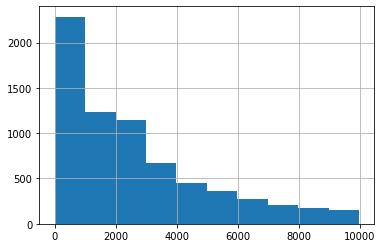

In [41]:
tx_user.query('Revenue < 10000')['Revenue'].hist()

In [42]:
import warnings
warnings.filterwarnings("ignore")

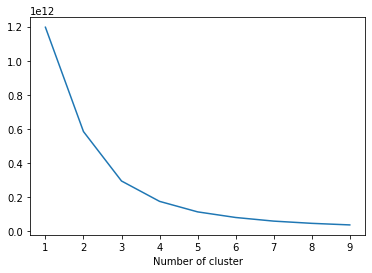

In [43]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [44]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [45]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [46]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,7556.0,3423.128733,3677.700173,0.00,704.5275,2196.500,4670.750,17538.96
1,479.0,31739.181357,14876.806460,17583.99,21136.2300,26896.800,35948.155,90457.40
2,24.0,155263.635417,61781.661144,98126.08,109629.8000,127179.795,179647.245,336762.31


In [47]:
tx_user.head()

,Customer No.,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,E23287,62,0,2,0,1830.43,0
1,10921,91,0,2,0,1895.23,0
2,10901,91,0,2,0,799.18,0
3,10884,91,0,2,0,1586.89,0
4,10648,91,0,1,0,0.00,0


In [48]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

In [49]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,73.296466,1.936209,2916.971941
1,43.668847,2.079722,3765.650773
2,16.553301,2.260421,4715.865721
3,15.178761,4.624779,16511.792248
4,10.228188,6.919463,40320.701275
5,4.714286,20.000000,119295.117143
6,3.000000,65.000000,135483.640000


In [50]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0    2179
1    2446
2    2711
3     565
4     149
5       7
6       2
Name: Recency, dtype: int64

In [51]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [52]:
tx_user['Segment'].value_counts()

Low-Value     7336
Mid-Value      714
High-Value       9
Name: Segment, dtype: int64

In [53]:
tx_user.head()

,Customer No.,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,E23287,62,0,2,0,1830.43,0,0,Low-Value
1,10921,91,0,2,0,1895.23,0,0,Low-Value
2,10901,91,0,2,0,799.18,0,0,Low-Value
3,10884,91,0,2,0,1586.89,0,0,Low-Value
4,10648,91,0,1,0,0.00,0,0,Low-Value


In [54]:
tx_6m.head()

,Unnamed: 0,Cust Type,Customer No.,Gate Pass Time,Invoice No,Job Card No,KMs Reading,Labour Total,Make,Misc Total,...,Service_Time,DBM Order,Item Category,Net value,Order Quantity,year,month,c_TA_KM,Service_days,c_TA_SD
0,516068,Retail,6427,00:00:00,7000034540,34123,79042,990.17,TATA MOTORS,0.0,...,2 days 13:33:46.000000000,34123.0,P001,990.17,1.0,2013,6,0,2,0
1,516069,Retail,6427,00:00:00,7000034540,34123,79042,990.17,TATA MOTORS,0.0,...,2 days 13:33:46.000000000,34123.0,P002,1809.17,8.5,2013,6,0,2,0
2,516070,Retail,13975,00:00:00,7000034541,34402,95390,0.00,HYUNDAI,0.0,...,0 days 00:25:58.000000000,34402.0,P010,6499.87,1.0,2013,6,0,0,0
3,516071,Retail,13975,00:00:00,7000034542,34174,95390,555.32,HYUNDAI,0.0,...,1 days 22:42:22.000000000,34174.0,P001,555.32,87.0,2013,6,0,1,0
4,516072,Retail,13975,00:00:00,7000034542,34174,95390,555.32,HYUNDAI,0.0,...,1 days 22:42:22.000000000,34174.0,P002,122.35,10.0,2013,6,0,1,0


In [55]:
#tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_6m['Revenue'] = tx_6m['Net value'] 

In [59]:
tx_user_6m = tx_6m.groupby('Customer No.')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['Customer No.','m6_Revenue']

In [60]:
tx_user_6m.head()

,Customer No.,m6_Revenue
0,10,2901.77
1,1000,749.42
2,10000,299.05
3,10001,5442.03
4,1001,1410.03


In [57]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='Customer No.', how='left')

In [61]:
tx_merge.tail()

,Customer No.,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
8054,13264,6,2,6,1,110031.22,2,5,High-Value,NaN
8055,13498,17,2,8,1,107431.93,2,5,High-Value,3575.13
8056,14667,0,2,4,1,124012.87,2,5,High-Value,19600.59
8057,10893,6,2,46,2,172841.20,2,6,High-Value,193170.12
8058,MFM15,0,2,84,2,98126.08,2,6,High-Value,115485.05


In [62]:
tx_merge = tx_merge.fillna(0)

In [63]:
tx_merge.groupby('Segment')['m6_Revenue'].mean()

Segment
High-Value    78538.976667
Low-Value      2328.660316
Mid-Value      8253.673305
Name: m6_Revenue, dtype: float64

In [64]:
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]

In [65]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

In [66]:
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

In [67]:
tx_merge.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,6798.0,461.088232,1019.521885,0.00,0.0000,0.000,0.0000,4624.42
1,916.0,8820.908373,3206.998989,4633.44,6115.7025,8001.310,10976.8325,16151.19
2,264.0,23631.390871,5910.629313,16286.24,18546.6100,22446.545,27235.8600,40369.65


In [68]:
tx_cluster = tx_merge.copy()

In [92]:
tx_cluster.LTVCluster.value_counts()

0    6798
1     916
2     264
Name: LTVCluster, dtype: int64

In [126]:
tx_cluster.loc[tx_cluster['LTVCluster']=='Mid-Value']

,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster


In [70]:
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,6798.0,461.088232,1019.521885,0.00,0.0000,0.000,0.0000,4624.42
1,916.0,8820.908373,3206.998989,4633.44,6115.7025,8001.310,10976.8325,16151.19
2,264.0,23631.390871,5910.629313,16286.24,18546.6100,22446.545,27235.8600,40369.65


In [128]:
tx_cluster.LTVCluster.value_counts()

0    6798
1     916
2     264
Name: LTVCluster, dtype: int64

In [75]:
tx_cluster2=tx_cluster

In [77]:
#tx_cluster2.drop('Customer No.',axis=1,inplace=True)

In [78]:
tx_class = pd.get_dummies(tx_cluster2)

In [79]:
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.923177
Frequency             0.156678
FrequencyCluster      0.134070
Segment_Mid-Value     0.130271
Revenue               0.119333
RevenueCluster        0.100897
OverallScore          0.098007
RecencyCluster        0.032842
Segment_High-Value    0.015430
Recency              -0.034584
Segment_Low-Value    -0.131158
Name: LTVCluster, dtype: float64

In [80]:
tx_class.head()

,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,62,0,2,0,1830.43,0,0,0.00,0,0,1,0
1,91,0,2,0,1895.23,0,0,1271.84,0,0,1,0
2,91,0,2,0,799.18,0,0,0.00,0,0,1,0
3,91,0,2,0,1586.89,0,0,0.00,0,0,1,0
4,91,0,1,0,0.00,0,0,0.00,0,0,1,0


In [91]:
len(tx_class)

7978

In [81]:
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

# xgb.XGBClassifier

In [83]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))


Accuracy of XGB classifier on training set: 0.86
Accuracy of XGB classifier on test set: 0.84


In [85]:
tx_class.groupby('LTVCluster').Recency.count()/tx_class.Recency.count()

LTVCluster
0    0.852093
1    0.114816
2    0.033091
Name: Recency, dtype: float64

In [86]:
y_pred = ltv_xgb_model.predict(X_test)

In [88]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       338
           1       0.00      0.00      0.00        46
           2       0.00      0.00      0.00        15

    accuracy                           0.84       399
   macro avg       0.28      0.33      0.31       399
weighted avg       0.72      0.84      0.78       399



In [90]:
len(tx_class)

7978

# RandomForestClassifier

In [95]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [114]:
rfc=RandomForestClassifier(criterion='entropy',max_depth=5,random_state=0)

In [115]:
rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, random_state=0)

In [116]:
y_pred_rfc=rfc.predict(X_test)

In [117]:
print(classification_report(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       338
           1       0.00      0.00      0.00        46
           2       0.00      0.00      0.00        15

    accuracy                           0.85       399
   macro avg       0.28      0.33      0.31       399
weighted avg       0.72      0.85      0.78       399



In [118]:
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(rfc.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(rfc.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.85
Accuracy of XGB classifier on test set: 0.85


In [119]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=8,random_state=0)

dt.fit(X_train,y_train)

y_pred_dt = dt.predict(X_test)
y_pred_dt_train = dt.predict(X_train)

print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       338
           1       0.67      0.04      0.08        46
           2       0.00      0.00      0.00        15

    accuracy                           0.85       399
   macro avg       0.51      0.35      0.33       399
weighted avg       0.80      0.85      0.79       399



In [120]:
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(dt.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(dt.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.86
Accuracy of XGB classifier on test set: 0.85
